# Mediapiple Facemesh + Texture

## references
- https://github.com/google/mediapipe/issues/1698
- https://github.com/google/mediapipe/issues/1798
- https://github.com/google/mediapipe/tree/master/mediapipe/modules/face_geometry/data
- https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
- https://github.com/google/mediapipe/blob/e6c19885c6d3c6f410c730952aeed2852790d306/mediapipe/modules/face_geometry/data/canonical_face_model.obj

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import skimage.io
from skimage.transform import PiecewiseAffineTransform, warp


In [ ]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    return ax

uv_path = "./data/uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

In [3]:
# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def load_obj(obj_filename):
    """ Ref: https://github.com/facebookresearch/pytorch3d/blob/25c065e9dafa90163e7cec873dbb324a637c68b7/pytorch3d/io/obj_io.py
    Load a mesh from a file-like object.
    """
    with open(obj_filename, 'r') as f:
        lines = [line.strip() for line in f]

    verts, uvcoords = [], []
    faces, uv_faces = [], []
    # startswith expects each line to be a string. If the file is read in as
    # bytes then first decode to strings.
    if lines and isinstance(lines[0], bytes):
        lines = [el.decode("utf-8") for el in lines]

    for line in lines:
        tokens = line.strip().split()
        if line.startswith("v "):  # Line is a vertex.
            vert = [float(x) for x in tokens[1:4]]
            if len(vert) != 3:
                msg = "Vertex %s does not have 3 values. Line: %s"
                raise ValueError(msg % (str(vert), str(line)))
            verts.append(vert)
        elif line.startswith("vt "):  # Line is a texture.
            tx = [float(x) for x in tokens[1:3]]
            if len(tx) != 2:
                raise ValueError(
                    "Texture %s does not have 2 values. Line: %s" % (str(tx), str(line))
                )
            uvcoords.append(tx)
        elif line.startswith("f "):  # Line is a face.
            # Update face properties info.
            face = tokens[1:]
            face_list = [f.split("/") for f in face]
            for vert_props in face_list:
                # Vertex index.
                faces.append(int(vert_props[0]))
                if len(vert_props) > 1:
                    if vert_props[1] != "":
                        # Texture index is present e.g. f 4/1/1.
                        uv_faces.append(int(vert_props[1]))

    verts = np.array(verts)
    uvcoords = np.array(uvcoords)
    faces = np.array(faces); faces = faces.reshape(-1, 3) - 1
    uv_faces = np.array(uv_faces); uv_faces = uv_faces.reshape(-1, 3) - 1
    return (
        verts,
        uvcoords,
        faces,
        uv_faces
    )

# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def write_obj(obj_name,
              vertices,
              faces,
              texture_name = "texture.jpg",
              colors=None,
              texture=None,
              uvcoords=None,
              uvfaces=None,
              inverse_face_order=False,
              normal_map=None,
              ):
    ''' Save 3D face model with texture. 
    Ref: https://github.com/patrikhuber/eos/blob/bd00155ebae4b1a13b08bf5a991694d682abbada/include/eos/core/Mesh.hpp
    Args:
        obj_name: str
        vertices: shape = (nver, 3)
        colors: shape = (nver, 3)
        faces: shape = (ntri, 3)
        texture: shape = (uv_size, uv_size, 3)
        uvcoords: shape = (nver, 2) max value<=1
    '''
    if os.path.splitext(obj_name)[-1] != '.obj':
        obj_name = obj_name + '.obj'
    mtl_name = obj_name.replace('.obj', '.mtl')
    texture_name
    material_name = 'FaceTexture'

    faces = faces.copy()
    # mesh lab start with 1, python/c++ start from 0
    faces += 1
    if inverse_face_order:
        faces = faces[:, [2, 1, 0]]
        if uvfaces is not None:
            uvfaces = uvfaces[:, [2, 1, 0]]

    # write obj
    with open(obj_name, 'w') as f:
        # first line: write mtlib(material library)
        # f.write('# %s\n' % os.path.basename(obj_name))
        # f.write('#\n')
        # f.write('\n')
        if texture is not None:
            f.write('mtllib %s\n\n' % os.path.basename(mtl_name))

        # write vertices
        if colors is None:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2]))
        else:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {} {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2], colors[i, 0], colors[i, 1], colors[i, 2]))

        # write uv coords
        if texture is None:
            for i in range(faces.shape[0]):
                f.write('f {} {} {}\n'.format(faces[i, 2], faces[i, 1], faces[i, 0]))
        else:
            for i in range(uvcoords.shape[0]):
                f.write('vt {} {}\n'.format(uvcoords[i,0], uvcoords[i,1]))
            f.write('usemtl %s\n' % material_name)
            # write f: ver ind/ uv ind
            uvfaces = uvfaces + 1
            for i in range(faces.shape[0]):
                f.write('f {}/{} {}/{} {}/{}\n'.format(
                    #  faces[i, 2], uvfaces[i, 2],
                    #  faces[i, 1], uvfaces[i, 1],
                    #  faces[i, 0], uvfaces[i, 0]
                    faces[i, 0], uvfaces[i, 0],
                    faces[i, 1], uvfaces[i, 1],
                    faces[i, 2], uvfaces[i, 2]
                )
                )
            # write mtl
            with open(mtl_name, 'w') as f:
                f.write('newmtl %s\n' % material_name)
                s = 'map_Kd {}\n'.format(os.path.basename(texture_name)) # map to image
                f.write(s)

                if normal_map is not None:
                    name, _ = os.path.splitext(obj_name)
                    normal_name = f'{name}_normals.png'
                    f.write(f'disp {normal_name}')
                    # out_normal_map = normal_map / (np.linalg.norm(
                    #     normal_map, axis=-1, keepdims=True) + 1e-9)
                    # out_normal_map = (out_normal_map + 1) * 0.5

                    cv2.imwrite(
                        normal_name,
                        # (out_normal_map * 255).astype(np.uint8)[:, :, ::-1]
                        normal_map
                    )
            skimage.io.imsave(texture_name, texture)

<AxesSubplot:>

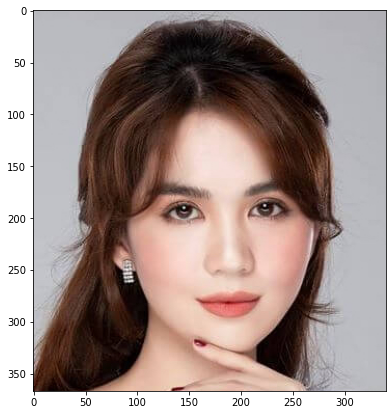

In [36]:
#image source: https://mydramalist.com/people/461-aragaki-yui
img_name = "ngoctrinh"
img_path = f"./data/{img_name}.jpg"
img_ori = skimage.io.imread(img_path)
imshow(img_ori)

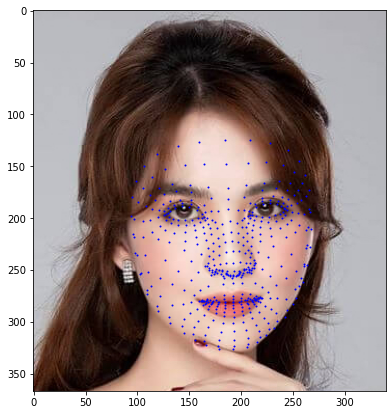

In [37]:
img = img_ori
H,W,_ = img.shape
#run facial landmark detection
with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        # refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(img)

assert len(results.multi_face_landmarks)==1 

face_landmarks = results.multi_face_landmarks[0]
keypoints = np.array([(W*point.x,H*point.y) for point in face_landmarks.landmark[0:468]])#after 468 is iris or something else
ax = imshow(img_ori)
ax.plot(keypoints[:, 0], keypoints[:, 1], '.b', markersize=2)
plt.show()

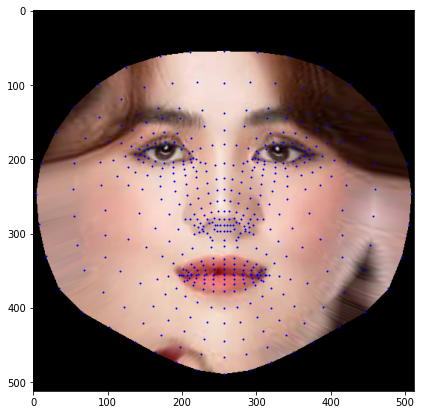

In [38]:
#https://scikit-image.org/docs/dev/auto_examples/transform/plot_piecewise_affine.html
H_new,W_new = 512,512
keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])

tform = PiecewiseAffineTransform()
tform.estimate(keypoints_uv,keypoints)
texture = warp(img_ori, tform, output_shape=(H_new,W_new))
texture = (255*texture).astype(np.uint8)

ax = imshow(texture)
ax.plot(keypoints_uv[:, 0], keypoints_uv[:, 1], '.b', markersize=2)
plt.show()

In [39]:
keypoints3d = np.array([(point.x,point.y,point.z) for point in face_landmarks.landmark[0:468]])

In [40]:
obj_filename = "./data/canonical_face_model.obj"
verts,uvcoords,faces,uv_faces = load_obj(obj_filename)

In [41]:
def normalize_keypoints(keypoints3d):
    center = keypoints3d[0]
    keypoints3d = keypoints3d - center
    axis1 = keypoints3d[165] - keypoints3d[391]
    axis2 = keypoints3d[2] - keypoints3d[0]
    axis3 = np.cross(axis2, axis1)
    axis3 = axis3/np.linalg.norm(axis3)
    axis2 = axis2/np.linalg.norm(axis2)
    axis1 = np.cross(axis3, axis2)
    axis1 = axis1/np.linalg.norm(axis1)
    U = np.array([axis3, axis2, axis1])
    keypoints3d = keypoints3d.dot(U)
    keypoints3d = keypoints3d - keypoints3d.mean(axis=0)
    return keypoints3d


vertices = normalize_keypoints(keypoints3d)

# borrowed from https://github.com/YadiraF/PRNet/blob/master/utils/write.py
obj_name = f"./results/{img_name}.obj"
write_obj(obj_name,
          vertices,
          faces,
          texture_name=f"./results/{img_name}.jpg",
          texture=texture,
          uvcoords=uvcoords,
          uvfaces=uv_faces,
        )
